In [66]:
import pandas as pd
import numpy as np

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
from sklearn.model_selection import KFold
from numpy import mean
from numpy import std
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Bankruptcy_data_Final.xlsx to Bankruptcy_data_Final.xlsx


In [68]:
import io
df = pd.read_excel(io.BytesIO(uploaded['Bankruptcy_data_Final.xlsx']))

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 92867 non-null  float64
 1   Liquidity           92625 non-null  float64
 2   Profitability       92625 non-null  float64
 3   Productivity        92625 non-null  float64
 4   Leverage Ratio      92846 non-null  float64
 5   Asset Turnover      92625 non-null  float64
 6   Operational Margin  87315 non-null  float64
 7   Return on Equity    92864 non-null  float64
 8   Market Book Ratio   92815 non-null  float64
 9   Assets Growth       86171 non-null  float64
 10  Sales Growth        86171 non-null  float64
 11  Employee Growth     85862 non-null  float64
 12  BK                  92872 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 9.2 MB


In [70]:
#Read and Understand Data, Look at describe factors to check for any anomolies / unusual points
df.head(5)
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EPS,92867.0,-14.461355,2195.467288,-3.840000e+05,-0.140000,0.330000,1.530000,55339.00
Liquidity,92625.0,-2.631237,121.610921,-2.596852e+04,0.020000,0.190000,0.400000,1.00
Profitability,92625.0,-29.537274,677.230667,-7.968200e+04,-0.640000,0.070000,0.310000,140.58
Productivity,92625.0,-1.222870,35.885556,-5.093000e+03,-0.060000,0.060000,0.110000,1102.00
Leverage Ratio,92846.0,1.345316,253.038093,-7.811000e+03,0.000000,0.280000,0.820000,75970.38
Asset Turnover,92625.0,1.053613,2.115945,-3.159000e+01,0.390000,0.830000,1.390000,276.38
Operational Margin,87315.0,-7.915485,214.460079,-3.017570e+04,-0.030000,0.060000,0.140000,394.47
Return on Equity,92864.0,-2.112382,352.596902,-8.887514e+04,-0.080000,0.030000,0.070000,39500.00
Market Book Ratio,92815.0,358.506265,26063.637981,-3.151500e+06,11.200000,58.280000,240.140000,3455419.33
Assets Growth,86171.0,1.294075,73.769522,-1.000000e+00,-0.052596,0.051844,0.192062,14231.00


In [71]:
df.isnull().values.any()

True

In [72]:
#check for NA values in every column = less than 10%
df.isnull().sum().sort_values(ascending = False)

Employee Growth       7010
Sales Growth          6701
Assets Growth         6701
Operational Margin    5557
Asset Turnover         247
Productivity           247
Profitability          247
Liquidity              247
Market Book Ratio       57
Leverage Ratio          26
Return on Equity         8
EPS                      5
BK                       0
dtype: int64

In [73]:
 df1 = df.dropna()  

In [74]:
#new df with all NA removed is 81,204 = 88% of original (only ~12% is lost)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81204 entries, 1 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 81204 non-null  float64
 1   Liquidity           81204 non-null  float64
 2   Profitability       81204 non-null  float64
 3   Productivity        81204 non-null  float64
 4   Leverage Ratio      81204 non-null  float64
 5   Asset Turnover      81204 non-null  float64
 6   Operational Margin  81204 non-null  float64
 7   Return on Equity    81204 non-null  float64
 8   Market Book Ratio   81204 non-null  float64
 9   Assets Growth       81204 non-null  float64
 10  Sales Growth        81204 non-null  float64
 11  Employee Growth     81204 non-null  float64
 12  BK                  81204 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 8.7 MB


In [75]:
#make sure all NAs are removed in new df1
df1.isnull().sum().sort_values(ascending = False)

BK                    0
Employee Growth       0
Sales Growth          0
Assets Growth         0
Market Book Ratio     0
Return on Equity      0
Operational Margin    0
Asset Turnover        0
Leverage Ratio        0
Productivity          0
Profitability         0
Liquidity             0
EPS                   0
dtype: int64

#Imbalance Data

Undersampling  BK Feature

In [76]:

# Shuffle the Dataset.
shuffled_df = df1.sample(frac=1,random_state=4)

# amount of fraud classes 492 rows.
bk_df = shuffled_df.loc[shuffled_df['BK'] == 1]

#Randomly select 492 observations.
non_bk_df = shuffled_df.loc[shuffled_df['BK'] == 0].sample(n=492,random_state=42)
normalized_df = pd.concat([bk_df, non_bk_df])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


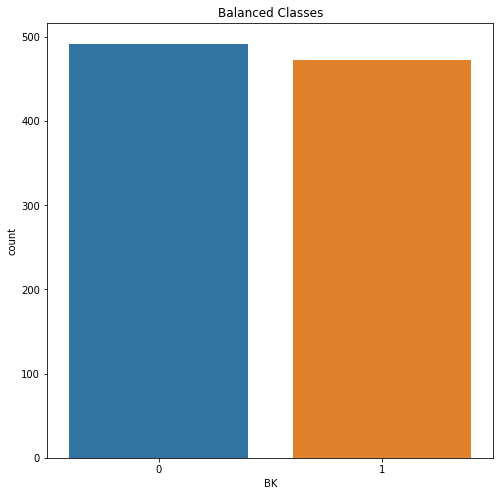

In [77]:

plt.figure(figsize=(8, 8))
sns.countplot('BK', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [80]:
#split data
feature_names = ['EPS', 'Liquidity', 'Profitability', 'Productivity', 'Leverage Ratio', 'Asset Turnover', 'Operational Margin', 'Return on Equity', 'Market Book Ratio', 'Assets Growth', 'Sales Growth', 'Employee Growth']
X =normalized_df[feature_names].to_numpy()
y = normalized_df['BK'].to_numpy()

In [81]:
#split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

type(X_train)
type(y_train)

numpy.ndarray

In [82]:
#decision Tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy",
                             min_samples_split=10, min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

In [83]:
class_names = [str(x) for x in clf.classes_]

In [84]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)

array([[90, 13],
       [15, 75]])

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       103
           1       0.85      0.83      0.84        90

    accuracy                           0.85       193
   macro avg       0.85      0.85      0.85       193
weighted avg       0.85      0.85      0.85       193



In [86]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_dt)))


Accuracy = 0.85
Kappa = 0.71
F1 Score = 0.84
Log Loss = 5.01


In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=22)
lr_clf.fit(X_train, y_train)

y_pred_lr = lr_clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:

lr_clf.coef_

array([[-7.50902912e-06, -2.89279160e-01,  2.93719310e-01,
        -9.20342722e-02,  4.49088445e-02, -1.55654743e+00,
         4.16140599e-01,  1.09841388e-04, -1.49861011e-05,
        -3.07980690e-01, -3.33533008e-01, -1.73454080e-01]])

In [ ]:
print(confusion_matrix(y_test, y_pred_lr))

[[16123    23]
 [   94     1]]


In [ ]:
print(classification_report(y_test, y_pred_lr, target_names=class_names))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16146
           1       0.04      0.01      0.02        95

    accuracy                           0.99     16241
   macro avg       0.52      0.50      0.51     16241
weighted avg       0.99      0.99      0.99     16241



In [ ]:
print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_lr)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_lr)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_lr)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_lr)))

Accuracy = 0.99
Kappa = 0.01
F1 Score = 0.02
Log Loss = 0.25
